# Monitoring Vertex AI Model 



## Overview

### What is Model Monitoring?

Model monitoring is only one piece of the ML Ops puzzle - it helps answer the following questions:

* How well do recent service requests match the training data used to build your model? This is called **training-serving skew**.
* How significantly are service requests evolving over time? This is called **drift detection**.

If production traffic differs from  training data, or varies substantially over time, that's likely to impact the quality of the answers your model produces. When that happens, you'd like to be alerted automatically and responsively.

## Learning Objectives

1. Deploy a pre-trained model.
2. Configure model monitoring.
3. Generate some artificial traffic.
4. Interpret the data reported by the model monitoring feature.

## Before you begin

### Setup your dependencies

In [1]:
# Import necessary libraries
import copy
import os
import pprint as pp
import random
import sys
import time

import google
import numpy as np
from google.cloud import aiplatform
from google.cloud.aiplatform_v1.services.endpoint_service import (
    EndpointServiceClient,
)
from google.cloud.aiplatform_v1.services.job_service import JobServiceClient
from google.cloud.aiplatform_v1.services.prediction_service import (
    PredictionServiceClient,
)
from google.cloud.aiplatform_v1.types.io import BigQuerySource
from google.cloud.aiplatform_v1.types.model_deployment_monitoring_job import (
    ModelDeploymentMonitoringJob,
    ModelDeploymentMonitoringObjectiveConfig,
    ModelDeploymentMonitoringScheduleConfig,
)
from google.cloud.aiplatform_v1.types.model_monitoring import (
    ModelMonitoringAlertConfig,
    ModelMonitoringObjectiveConfig,
    SamplingStrategy,
    ThresholdConfig,
)
from google.cloud.aiplatform_v1.types.prediction_service import PredictRequest
from google.protobuf import json_format
from google.protobuf.duration_pb2 import Duration
from google.protobuf.struct_pb2 import Value

PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
REGION = "us-central1"
SUFFIX = "aiplatform.googleapis.com"
API_ENDPOINT = f"{REGION}-{SUFFIX}"
PREDICT_API_ENDPOINT = f"{REGION}-prediction-{SUFFIX}"
!gcloud config set project $PROJECT
!gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


## The example model

The model you'll use in this notebook is based on [this blog post](https://cloud.google.com/blog/topics/developers-practitioners/churn-prediction-game-developers-using-google-analytics-4-ga4-and-bigquery-ml). The idea behind this model is that your company has extensive log data describing how your game users have interacted with the site. The raw data contains the following categories of information:

- identity - unique player identitity numbers
- demographic features - information about the player, such as the geographic region in which a player is located
- behavioral features - counts of the number of times a  player has triggered certain game events, such as reaching a new level
- churn propensity - this is the label or target feature, it provides an estimated probability that this player will churn, i.e. stop being an active player.

The blog article referenced above explains how to use BigQuery to store the raw data, pre-process it for use in machine learning, and train a model.

## Import your model

The churn propensity model you'll be using in this notebook has been trained in BigQuery ML and exported to `../models`

In the next cells, we will copy the model to GCS and upload to Vertex AI.

Copy model to GCS

In [2]:
ARTIFACT = f"gs://{PROJECT}/models/churn"
!gsutil -m cp -r ../models/churn {ARTIFACT}

Copying file://../models/churn/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://../models/churn/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://../models/churn/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://../models/churn/assets/operating_system.txt [Content-Type=text/plain]...
Copying file://../models/churn/assets/language.txt [Content-Type=text/plain]... 
Copying file://../models/churn/assets/user_pseudo_id.txt [Content-Type=text/plain]...
Copying file://../models/churn/assets/country.txt [Content-Type=text/plain]...  
/ [7/7 files][381.4 KiB/381.4 KiB] 100% Done                                    
Operation completed over 7 objects/381.4 KiB.                                    


Upload model to Vertex AI. To upload a model to Vertex, we provide:
- `--container-image-uri`: URI of the serving container file.
- `--display-name`: The display name of the model.
- `--artifact-uri`: Path to the directory containing the Model artifact and any of its supporting files.

In [3]:
MODEL_NAME = 'churn'
IMAGE = 'us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-4:latest'
output = !gcloud --quiet ai models upload\
            --container-image-uri={IMAGE}\
            --artifact-uri={ARTIFACT}\
            --display-name={MODEL_NAME}\
            --format="value(model)"

print(f'model output: {output}')
MODEL_ID = output[1].split("/")[-1]
print(f'Model {MODEL_NAME}/{MODEL_ID} created.')

model output: ['Using endpoint [https://us-central1-aiplatform.googleapis.com/]', 'projects/693210680039/locations/us-central1/models/4515091722904010752', 'Waiting for operation [1216981869539622912]...', '............................................................done.']
Model churn/4515091722904010752 created.


## Deploy your endpoint

Now that you've imported your model into your project, you need to create an endpoint to serve your model.

Run the next cell to create an endpoint and deploy your model to it. **This will take about ten minutes to complete.**

In [4]:
# Deploy your model to the endpoint
ENDPOINT_NAME = "churn"
output = !gcloud --quiet ai endpoints create\
            --display-name={ENDPOINT_NAME}\
            --format="value(name)"
print(f"endpoint output: {output}")
ENDPOINT = output[-1]
ENDPOINT_ID = ENDPOINT.split("/")[-1]
output = !gcloud --quiet ai endpoints deploy-model {ENDPOINT_ID}\
            --display-name={ENDPOINT_NAME}\
            --model={MODEL_ID}\
            --traffic-split="0=100"
DEPLOYED_MODEL_ID = output[1].split()[-1][:-1]
print(
    f"Model {MODEL_NAME}/{MODEL_ID}/{DEPLOYED_MODEL_ID} deployed to Endpoint", 
    f"{ENDPOINT_NAME}/{ENDPOINT_ID}/{ENDPOINT}."
)

endpoint output: ['Using endpoint [https://us-central1-aiplatform.googleapis.com/]', 'Waiting for operation [6628619771778695168]...', '.....done.', 'Created Vertex AI endpoint: projects/693210680039/locations/us-central1/endpoints/6623924238652801024.', 'projects/693210680039/locations/us-central1/endpoints/6623924238652801024']
Model churn/4515091722904010752/[4322776762565001216].. deployed to Endpoint churn/6623924238652801024/projects/693210680039/locations/us-central1/endpoints/6623924238652801024.


## Run a prediction test

Now that you have imported a model and deployed that model to an endpoint, you are ready to verify that it's working. Run the next cell to send a test prediction request. If everything works as expected, you should receive a JSON response.

In [5]:
DEFAULT_INPUT = {
    "cnt_ad_reward": 0,
    "cnt_challenge_a_friend": 0,
    "cnt_completed_5_levels": 1,
    "cnt_level_complete_quickplay": 3,
    "cnt_level_end_quickplay": 5,
    "cnt_level_reset_quickplay": 2,
    "cnt_level_start_quickplay": 6,
    "cnt_post_score": 34,
    "cnt_spend_virtual_currency": 0,
    "cnt_use_extra_steps": 0,
    "cnt_user_engagement": 120,
    "country": "Denmark",
    "dayofweek": 3,
    "julianday": 254,
    "language": "da-dk",
    "month": 9,
    "operating_system": "IOS",
    "user_pseudo_id": "104B0770BAE16E8B53DF330C95881893",
}

endpoint = aiplatform.Endpoint(ENDPOINT)
endpoint.predict([DEFAULT_INPUT])

Prediction(predictions=[{'churned_probs': [0.8705776921658448, 0.1294223078341552], 'churned_values': ['1', '0'], 'predicted_churned': ['1']}], deployed_model_id='8309906572591497216', explanations=None)

Taking a closer look at the results, we see the following elements:

- **churned_values** - a set of possible values (0 and 1) for the target field
- **churned_probs** - a corresponding set of probabilities for each possible target field value 
- **predicted_churn** - based on the churned_probs, (1) has a higher probability so the predicted value of the target field is (1)

## Start your monitoring job
**NOTE** If a Model Monitoring job already exists for your endpoint, trying to create another one will cause an error. If you want to change the configuration of an existing Model Monitoring job you would need to update the configuration, not create a new one. 

Now that you've created an endpoint to serve prediction requests on your model, you're ready to start a monitoring job to keep an eye on model quality and to alert you if and when input begins to deviate in ways that may impact your model's prediction quality.

In this section, you will configure and create a model monitoring job for the churn propensity model.

### Configure Skew and Drift Thresholds

To configure the Model Monitoring job for skew and/or drift detection, you can provide the following:
- `skew_config`: A configuration specifying features to monitor for training-serving skew and threshold values to alert if exceeded. To configure this you will:
    * Create a dictionary where the keys are the feature names you want to monitor and the values are of type
    `ThresholdConfig`. 
    * Wrap that dictionary with `TrainingPredictionSkewDetectionConfig`

- `drift_config`: A configuration specifying feature to monitor for drift and threshold values to alert if exceeded. To configure this you will:
    * Create a dictionary with the same structure as for `skew_config`.
    * Wrap that dictionary with `PredictionDriftDetectionConfig`


Recall, for categorical features, the threshold is compared against the [L-infinity distance](https://en.wikipedia.org/wiki/Chebyshev_distance).

For numeric features, the threshold is compared against the [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence).

In [6]:
# TODO: Set skew_thresholds to monitor country, language, and cnt_user_engagement
# TODO: Set the thresholds on these features to 0.001, 0.001, and 0.5

skew_thresholds = {
    "country": ThresholdConfig(value=0.001),
    "language": ThresholdConfig(value=0.001),
    "cnt_user_engagement": ThresholdConfig(value=0.5),
}

drift_thresholds = {
    "country": ThresholdConfig(value=0.001),
    "language": ThresholdConfig(value=0.001),
    "cnt_user_engagement": ThresholdConfig(value=0.5),
}

skew_config = (
    ModelMonitoringObjectiveConfig.TrainingPredictionSkewDetectionConfig(
        skew_thresholds=skew_thresholds
    )
)
drift_config = ModelMonitoringObjectiveConfig.PredictionDriftDetectionConfig(
    drift_thresholds=drift_thresholds
)

Now that we have specified skew and drift configs, we will create a `ModelMonitoringObjectiveConfig`. This needs three things:
- `training_dataset`: The location of the training dataset so it can compute skew between live prediction data and the training data.
- `training_prediction_skew_detection_config`: The skew_config specified above.
- `prediction_drift_detection_config`: The drift_config specified above.

The final command in the following cell takes a `ModelMonitoringObjectiveConfig` and the ID of the deployed model to create a `ModelDeploymentMonitoringObjectiveConfig`. This is what we provide to the Model Monitoring create job itself.

In [7]:
# Training dataset to enable training-serving skew detection
training_dataset = ModelMonitoringObjectiveConfig.TrainingDataset(
    target_field="churned"
)

# Training data is in a publically available BQ table.
training_dataset.bigquery_source = BigQuerySource(
    input_uri="bq://mco-mm.bqmlga4.train"
)

# Set up objective config
objective_config = ModelMonitoringObjectiveConfig(
    training_dataset=training_dataset,
    training_prediction_skew_detection_config=skew_config,
    prediction_drift_detection_config=drift_config,
)

# This is what gets passed to the monitoring job create method
monitoring_objective_configs = [
    ModelDeploymentMonitoringObjectiveConfig(
        objective_config=objective_config,
        deployed_model_id=endpoint.list_models()[0].id,
    )
]

### Configure sampling, scheduling, and alerting. 
The last things to configure before creating the Model Monitoring job are sampling, scheduling, and alerting.
- `sampling_config`: A configuration for the Model Monitoring job that specifies what data to include each time the monitoring job runs. You can use `RandomSampleConfig` to randomly sample a percentage, specified as `sample_rate`, of live data. 
- `schedule_config`: A configuration for the Model Monitoring job that specifies when to trigger the job. You can use `monitor_interval` which specifies how often to trigger the job (in seconds). This can be thought of as the "window size" of data used for analysis every time the monitoring job runs. If you set this to 3600 seconds (this is the minimum possible value) then the monitoring job will run every 3600 seconds, analyzing sampled data that the deployed model has seen in the last 3600 seconds. 
- `alerting_config`: A configuration for the Model Monitoring job that specifies how to alert. You can configure automated email notifications by specifying `user_emails` in a `EmailAlertConfig`.

In [8]:
# TODO: Replace with email you want alerts/notifactions to be sent
USER_EMAIL = "[your-email@email.com]"

# Create sampling config to randomly sample 80% of live data
sampling_config = SamplingStrategy(
    random_sample_config=SamplingStrategy.RandomSampleConfig(sample_rate=0.8)
)

# Create schedule configuration to trigger monitoring job every 3600 seconds
# The minimum time window supported is 3600 seconds
schedule_config = ModelDeploymentMonitoringScheduleConfig(
    monitor_interval=Duration(seconds=3600)
)

# Create alerting configuration.
email_config = ModelMonitoringAlertConfig.EmailAlertConfig(
    user_emails=[USER_EMAIL]
)
alerting_config = ModelMonitoringAlertConfig(email_alert_config=email_config)

# Create the monitoring job.
job = ModelDeploymentMonitoringJob(
    display_name="churn",
    endpoint=ENDPOINT,
    model_deployment_monitoring_objective_configs=monitoring_objective_configs,
    logging_sampling_strategy=sampling_config,
    model_deployment_monitoring_schedule_config=schedule_config,
    model_monitoring_alert_config=alerting_config,
)
# Create client
options = dict(api_endpoint=API_ENDPOINT)
client = JobServiceClient(client_options=options)

# Create Monitoring job
parent = f"projects/{PROJECT}/locations/{REGION}"

try:
    response = client.create_model_deployment_monitoring_job(
        parent=parent, model_deployment_monitoring_job=job
    )

    print("Created monitoring job:")
    print(response)

except google.api_core.exceptions.FailedPrecondition:
    print(
        "Model Monitoring may already enabled on this endpoint.",
        "Please update instead of creating a new job",
    )

Created monitoring job:
name: "projects/693210680039/locations/us-central1/modelDeploymentMonitoringJobs/7538703069555458048"
display_name: "churn"
endpoint: "projects/693210680039/locations/us-central1/endpoints/6623924238652801024"
state: JOB_STATE_PENDING
schedule_state: OFFLINE
model_deployment_monitoring_objective_configs {
  deployed_model_id: "8309906572591497216"
  objective_config {
    training_dataset {
      bigquery_source {
        input_uri: "bq://mco-mm.bqmlga4.train"
      }
      target_field: "churned"
    }
    training_prediction_skew_detection_config {
      skew_thresholds {
        key: "cnt_user_engagement"
        value {
          value: 0.5
        }
      }
      skew_thresholds {
        key: "country"
        value {
          value: 0.001
        }
      }
      skew_thresholds {
        key: "language"
        value {
          value: 0.001
        }
      }
    }
    prediction_drift_detection_config {
      drift_thresholds {
        key: "cnt_user_en

After a minute or two, you should receive an email at the address you configured above for USER_EMAIL. This email confirms successful deployment of your monitoring job.


As your monitoring job collects data, measurements are stored in Google Cloud Storage and you are free to examine your data at any time. The path to this data can be found in the email received, specified as: Statistics and Anomalies Root Path(Google Cloud Storage).


You will notice the following components in these Cloud Storage paths:

- **cloud-ai-platform-..** - This is a bucket created for you and assigned to capture your service's prediction data. Each monitoring job you create will trigger creation of a new folder in this bucket.
- **[model_monitoring|instance_schemas]/job-..** - This is your unique monitoring job number, which you can see above in both the response to your job creation requesst and the email notification. 
- **instance_schemas/job-../analysis** - This is the monitoring jobs understanding and encoding of your training data's schema (field names, types, etc.).
- **instance_schemas/job-../predict** - This is predictions made to your model after the current monitoring job was enabled.
- **model_monitoring/job-../serving** - This folder is used to record data relevant to drift calculations. It contains measurement summaries for every hour your model serves traffic.
- **model_monitoring/job-../training** - This folder is used to record data relevant to training-serving skew calculations. It contains an ongoing summary of prediction data relative to training data.

## Generate test data to trigger alerting

Now you are ready to test the monitoring function. Run the following cell, which will generate fabricated test predictions designed to trigger the thresholds you specified above. It takes about five minutes to run this cell and at least an hour to assess and report anamolies in skew or drift so after running this cell, feel free to proceed with the notebook and you'll see how to examine the resulting alert later.

`monitoring_test()` is designed to send data through the deployed model with feature distributions significantly different than the training set. This should trigger the training-serving skew detection for for both `country` and `language`, as the L-infinity metric between the training dataset, and the data sent to the deployed model in `monitoring_test()` will be above the configured threshold of 0.001.

In [9]:
# Sampling distributions for categorical features. We will use this to
# generate synthetic data.
DAYOFWEEK = {1: 1040, 2: 1223, 3: 1352, 4: 1217, 5: 1078, 6: 1011, 7: 1110}
LANGUAGE = {
    "en-us": 4807,
    "en-gb": 678,
    "ja-jp": 419,
    "en-au": 310,
    "en-ca": 299,
    "de-de": 147,
    "en-in": 130,
    "en": 127,
    "fr-fr": 94,
    "pt-br": 81,
    "es-us": 65,
    "zh-tw": 64,
    "zh-hans-cn": 55,
    "es-mx": 53,
    "nl-nl": 37,
    "fr-ca": 34,
    "en-za": 29,
    "vi-vn": 29,
    "en-nz": 29,
    "es-es": 25,
}
OS = {"IOS": 3980, "ANDROID": 3798, "null": 253}
MONTH = {6: 3125, 7: 1838, 8: 1276, 9: 1718, 10: 74}
COUNTRY = {
    "United States": 4395,
    "India": 486,
    "Japan": 450,
    "Canada": 354,
    "Australia": 327,
    "United Kingdom": 303,
    "Germany": 144,
    "Mexico": 102,
    "France": 97,
    "Brazil": 93,
    "Taiwan": 72,
    "China": 65,
    "Saudi Arabia": 49,
    "Pakistan": 48,
    "Egypt": 46,
    "Netherlands": 45,
    "Vietnam": 42,
    "Philippines": 39,
    "South Africa": 38,
}

# Means and standard deviations for numerical features.
# We will use this to create skewed synthetic data for our
# model to serve predictions on
MEAN_SD = {
    "julianday": (204.6, 34.7),
    "cnt_user_engagement": (30.8, 53.2),
    "cnt_level_start_quickplay": (7.8, 28.9),
    "cnt_level_end_quickplay": (5.0, 16.4),
    "cnt_level_complete_quickplay": (2.1, 9.9),
    "cnt_level_reset_quickplay": (2.0, 19.6),
    "cnt_post_score": (4.9, 13.8),
    "cnt_spend_virtual_currency": (0.4, 1.8),
    "cnt_ad_reward": (0.1, 0.6),
    "cnt_challenge_a_friend": (0.0, 0.3),
    "cnt_completed_5_levels": (0.1, 0.4),
    "cnt_use_extra_steps": (0.4, 1.7),
}


def random_uid():
    digits = [str(i) for i in range(10)] + ["A", "B", "C", "D", "E", "F"]
    return "".join(random.choices(digits, k=32))


# Generate test predictions to trigger the thresholds
def monitoring_test(count, sleep, perturb_num={}, perturb_cat={}):
    # Use random sampling and mean/sd with gaussian distribution to model
    # training data. Then modify sampling distros for two categorical features
    # and mean/sd for two numerical features.
    mean_sd = MEAN_SD.copy()
    country = COUNTRY.copy()
    for k, (mean_fn, sd_fn) in perturb_num.items():
        orig_mean, orig_sd = MEAN_SD[k]
        mean_sd[k] = (mean_fn(orig_mean), sd_fn(orig_sd))
    for k, v in perturb_cat.items():
        country[k] = v
    for i in range(0, count):
        input = DEFAULT_INPUT.copy()
        input["user_pseudo_id"] = str(random_uid())
        input["country"] = random.choices([*country], list(country.values()))[0]
        input["dayofweek"] = random.choices(
            [*DAYOFWEEK], list(DAYOFWEEK.values())
        )[0]
        input["language"] = str(
            random.choices([*LANGUAGE], list(LANGUAGE.values()))[0]
        )
        input["operating_system"] = str(
            random.choices([*OS], list(OS.values()))[0]
        )
        input["month"] = random.choices([*MONTH], list(MONTH.values()))[0]
        for key, (mean, sd) in mean_sd.items():
            sample_val = round(float(np.random.normal(mean, sd, 1)))
            val = max(sample_val, 0)
            input[key] = val
        print(f"Sending prediction {i}")
        try:
            endpoint.predict([input])
        except Exception:
            print("prediction request failed")
        time.sleep(sleep)
    print("Test Completed.")


test_time = 300
tests_per_sec = 1
sleep_time = 1 / tests_per_sec
iterations = test_time * tests_per_sec
perturb_num = {"cnt_user_engagement": (lambda x: x * 3, lambda x: x / 3)}
perturb_cat = {"Japan": max(COUNTRY.values()) * 2}
monitoring_test(iterations, sleep_time, perturb_num, perturb_cat)

Sending prediction 0
Sending prediction 1
Sending prediction 2
Sending prediction 3
Sending prediction 4
Sending prediction 5
Sending prediction 6
Sending prediction 7
Sending prediction 8
Sending prediction 9
Sending prediction 10
Sending prediction 11
Sending prediction 12
Sending prediction 13
Sending prediction 14
Sending prediction 15
Sending prediction 16
Sending prediction 17
Sending prediction 18
Sending prediction 19
Sending prediction 20
Sending prediction 21
Sending prediction 22
Sending prediction 23
Sending prediction 24
Sending prediction 25
Sending prediction 26
Sending prediction 27
Sending prediction 28
Sending prediction 29
Sending prediction 30
Sending prediction 31
Sending prediction 32
Sending prediction 33
Sending prediction 34
Sending prediction 35
Sending prediction 36
Sending prediction 37
Sending prediction 38
Sending prediction 39
Sending prediction 40
Sending prediction 41
Sending prediction 42
Sending prediction 43
Sending prediction 44
Sending prediction 4

## Interpret your results

While waiting for your results, which may take up to an hour and half, you can read ahead to get sense of the alerting experience.

### Here's what a sample email alert looks like...



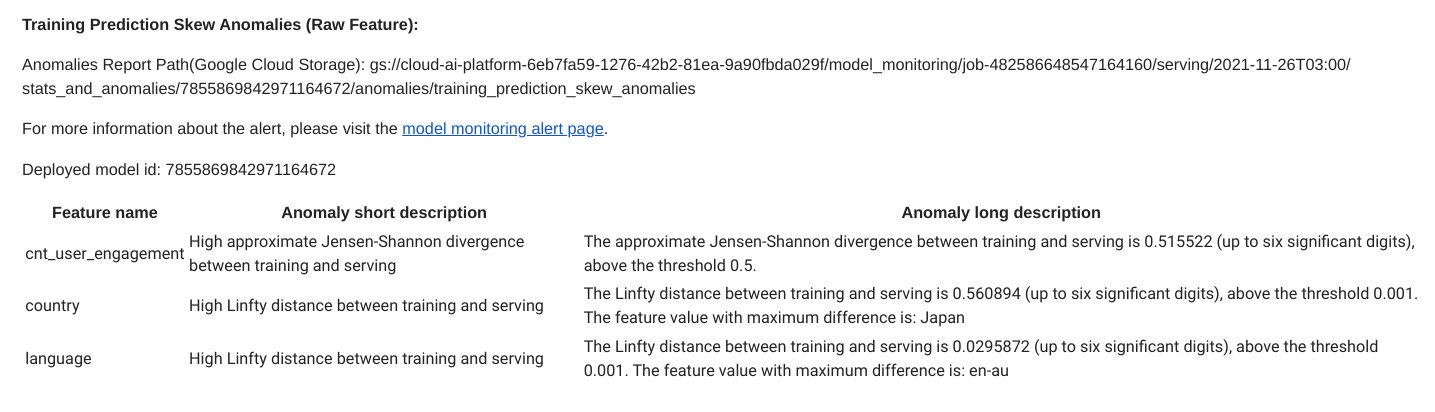

This email is warning you that the *country* and *language* feature values seen in production have skewed above your threshold between training and serving your model. It's also telling you that the *cnt_user_engagement* has skewed above your threshold between training and serving.

### Monitoring results in the Cloud Console

You can examine your model monitoring data from the [Cloud Console](https://console.cloud.google.com/vertex-ai/endpoints). Below is a screenshot of those capabilities. Note that you can see if monitoring is enabled or disabled, as well as see if there are any recent alerts. If there are recent alerts, you can drill down to see the recent alerts and information about what triggered them. 

#### Monitoring Status



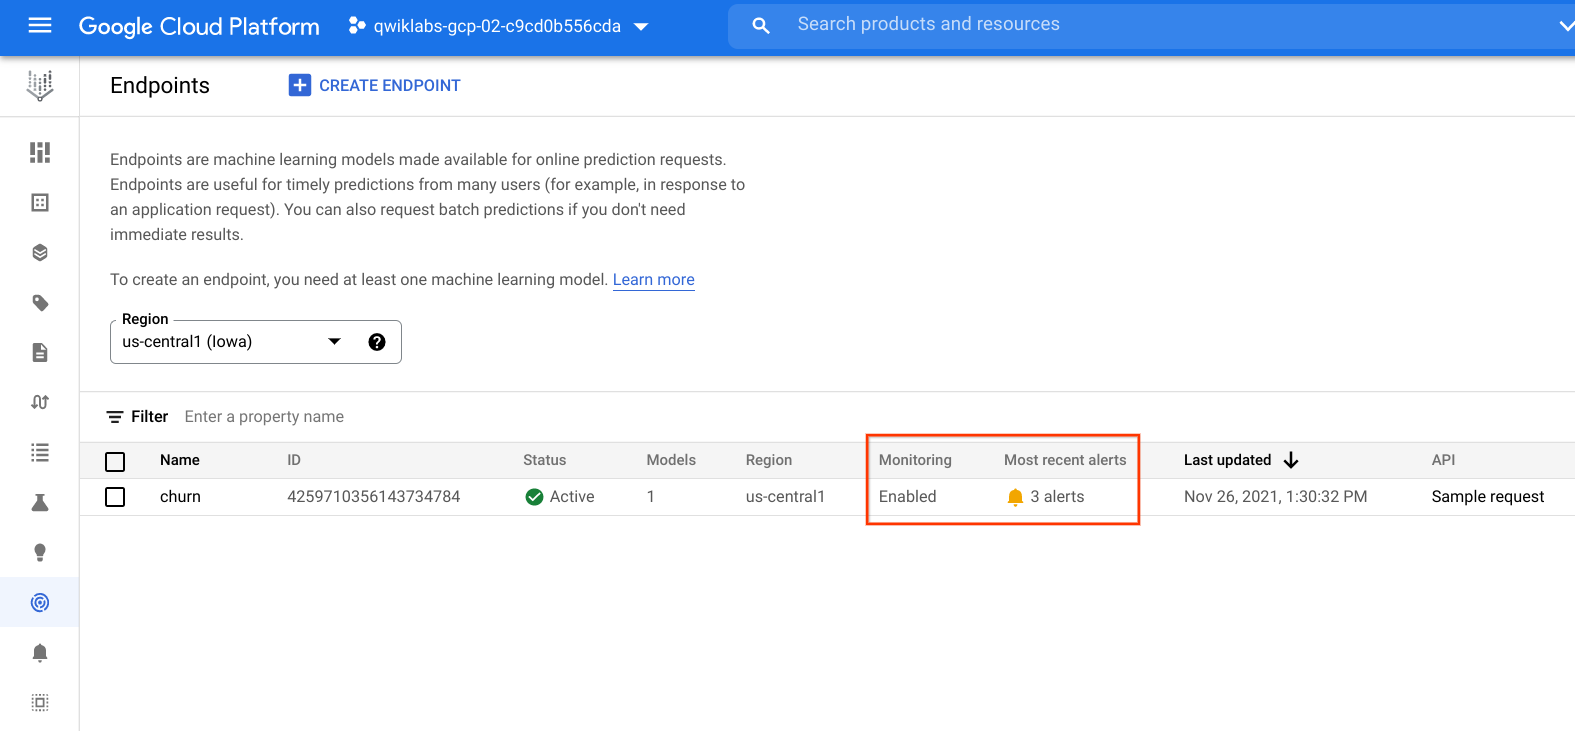

#### Monitoring Alerts



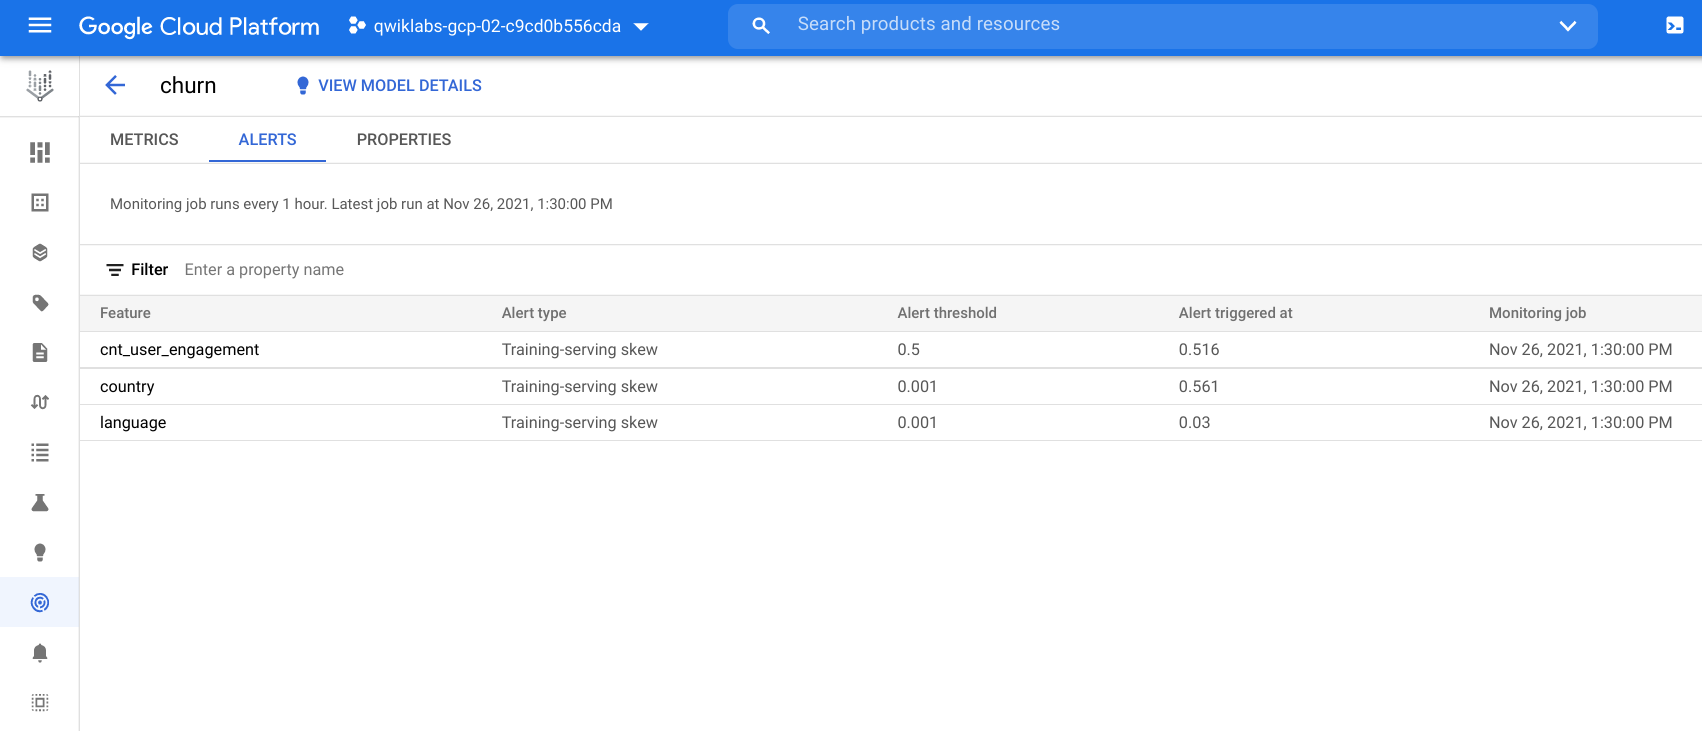

## Learn more about model monitoring

Check out the following resources to learn more about model monitoring and ML Ops.

- [TensorFlow Data Validation](https://www.tensorflow.org/tfx/guide/tfdv)
- [Data Understanding, Validation, and Monitoring At Scale](https://blog.tensorflow.org/2018/09/introducing-tensorflow-data-validation.html)
- [Vertex Product Documentation](https://cloud.google.com/vertex-ai/docs)
- [Model Monitoring Reference Docs](https://cloud.google.com/vertex-ai/docs/model-monitoring)
- [Model Monitoring blog article](https://cloud.google.com/blog/topics/developers-practitioners/monitor-models-training-serving-skew-vertex-ai)